In [165]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::852382942743:role/service-role/AmazonSageMaker-ExecutionRole-20200713T184760
CPU times: user 128 ms, sys: 24 ms, total: 151 ms
Wall time: 206 ms


In [166]:

from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


In [167]:
bucket = sess.default_bucket()
prefix = 'Clover'

In [168]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 28.1 µs


In [169]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

In [170]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [171]:

od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [172]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=2,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=1070,
                             num_training_samples=9223) 

In [173]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [174]:
od_model.fit(inputs=data_channels, logs=True)

2021-03-08 18:57:03 Starting - Starting the training job...
2021-03-08 18:57:19 Starting - Launching requested ML instancesProfilerReport-1615229823: InProgress
......
2021-03-08 18:58:33 Starting - Preparing the instances for training.........
2021-03-08 19:00:02 Downloading - Downloading input data....................................
2021-03-08 19:06:06 Training - Downloading the training image..Docker entrypoint called with argument(s): train

2021-03-08 19:06:26 Training - Training image download completed. Training in progress.[03/08/2021 19:06:24 INFO 139683683608384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', 

In [175]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-----------------!

In [202]:
file_name = "clover_test4.jpg"
with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [203]:
import json

#object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b, initial_args={'ContentType':'image/jpeg'})
detections = json.loads(results)
print (detections)

{'prediction': [[1.0, 0.9678579568862915, 0.030159085988998413, 0.30057138204574585, 0.3782065212726593, 0.7395212054252625], [1.0, 0.8800473809242249, 0.25775349140167236, 0.5565650463104248, 0.6435603499412537, 0.9607661962509155], [1.0, 0.8333286046981812, 0.0, 0.6450942754745483, 0.27410387992858887, 1.0], [1.0, 0.8097399473190308, 0.6626226902008057, 0.07759945094585419, 0.9531989097595215, 0.5021077990531921], [1.0, 0.8055989742279053, 0.7097148299217224, 0.6156083941459656, 0.9825463891029358, 0.9757998585700989], [1.0, 0.7055338621139526, 0.5694361925125122, 0.1327325701713562, 0.8638293743133545, 0.4634917378425598], [1.0, 0.6855125427246094, 0.1266273409128189, 0.11250744760036469, 0.4157712459564209, 0.45367103815078735], [0.0, 0.5213634371757507, 0.5028835535049438, 0.36732447147369385, 0.6421170234680176, 0.5214092135429382], [1.0, 0.48671257495880127, 0.4024682641029358, 0.32301002740859985, 0.5566460490226746, 0.51361483335495], [0.0, 0.48304980993270874, 0.4056650400161

In [206]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

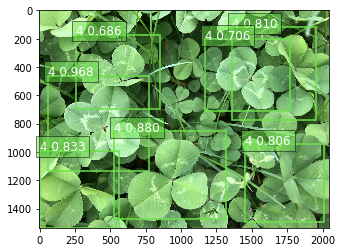

In [208]:

object_categories = ['3','4']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.6

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [112]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:852382942743:endpoint/object-detection-2021-01-26-18-59-12-901".